# Proposal

## Aim:

To make prediction of SalePrice based on categorical data with past data as training set. Apply three models, multiple linear regression, decision tree, and random forest to make forecast.

## Primary Objective:

- To fill columns with na values

- Find outliers that may affect outcome

- Concatenate past training data with new test data

- To find the SalePrice of our new test set

## Secondary Objective:

- Find values other than 0 that can fill the missing columns to improve accuracy.

- Find better models, if so, that can improve accuracy

In [575]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score
from sklearn.metrics import r2_score

import warnings
warnings.filterwarnings("ignore")

### Data preparation

In [576]:
house = pd.read_csv('./train.csv', delimiter = ',')
test_data = pd.read_csv('./test.csv', delimiter = ',')

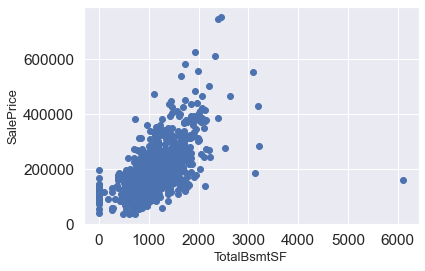

In [577]:
fig, ax = plt.subplots()
ax.scatter(x = house['TotalBsmtSF'], y = house['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('TotalBsmtSF', fontsize=13)
plt.show()

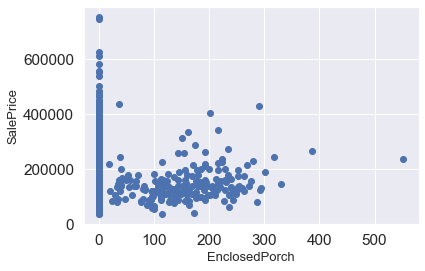

In [578]:
fig, ax = plt.subplots()
ax.scatter(x = house['EnclosedPorch'], y = house['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('EnclosedPorch', fontsize=13)
plt.show()

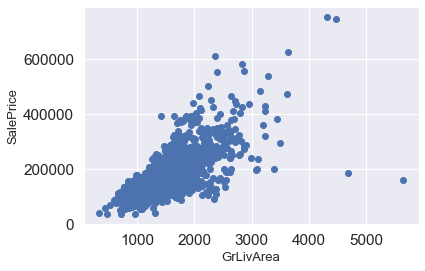

In [579]:
fig, ax = plt.subplots()
ax.scatter(x = house['GrLivArea'], y = house['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

In [580]:
house = house.drop(columns = ['Id'])
house = house.drop(house[(house['GrLivArea'] > 4000) & (house['SalePrice'] < 300000)].index)
house = house.drop(house[(house['TotalBsmtSF'] > 6000) & (house['SalePrice'] < 300000)].index)
house = house.drop(house[(house['EnclosedPorch'] > 500) & (house['SalePrice'] < 300000)].index)

In [581]:
total = house.isnull().sum().sort_values(ascending=False)  
percent = (house.isnull().sum() / house.isnull().count()).sort_values(ascending=False)*100  
get_unique = house.nunique()                                   
modify = pd.concat([total, percent, get_unique], axis=1, 
                        keys=['Total No of missing val', '% of Missing val','No of unique val'], sort = False)
print(modify.head(20))

              Total No of missing val  % of Missing val  No of unique val
PoolQC                           1452         99.656829                 3
MiscFeature                      1403         96.293754                 4
Alley                            1366         93.754290                 2
Fence                            1177         80.782430                 4
FireplaceQu                       690         47.357584                 5
LotFrontage                       259         17.776253               110
GarageYrBlt                        81          5.559369                97
GarageCond                         81          5.559369                 5
GarageType                         81          5.559369                 6
GarageFinish                       81          5.559369                 3
GarageQual                         81          5.559369                 5
BsmtExposure                       38          2.608099                 4
BsmtFinType2                       38 

Text(0.5, 1.0, 'Percent missing data by feature')

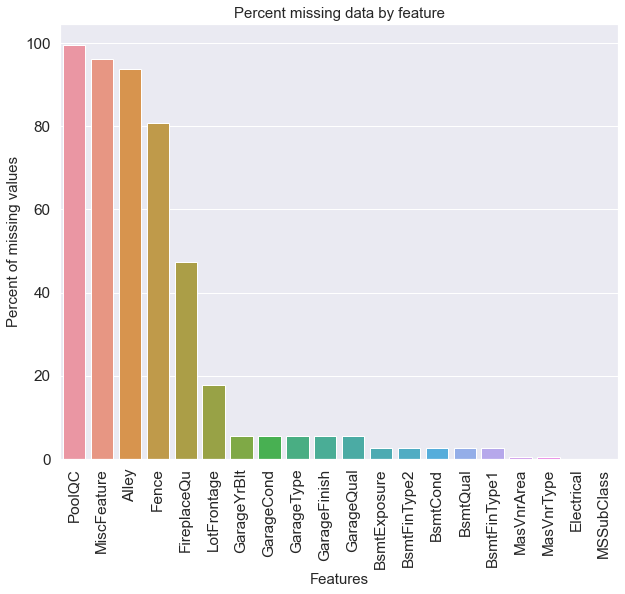

In [582]:
f, ax = plt.subplots(figsize=(10, 8))
plt.xticks(rotation='90')
sns.barplot(x = percent[:20].index, y = percent[:20])
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

As PoolQC, MiscFeature, and Alley have high percentages of missing value that greater than 90%, we will drop all of them.

### Target

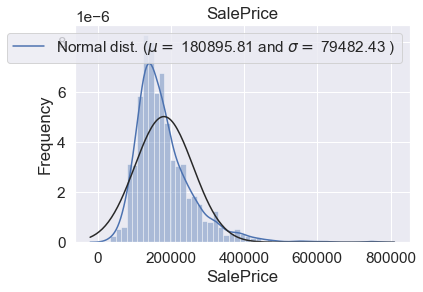

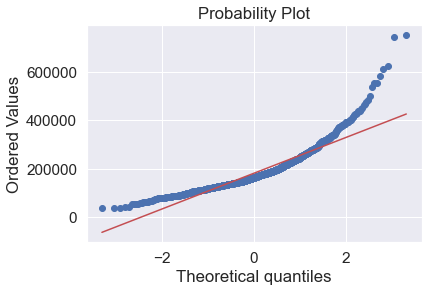

In [583]:
from scipy.stats import norm
from scipy import stats

sns.distplot(house['SalePrice'] , fit=norm);
(mu, sigma) = norm.fit(house['SalePrice'])

plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice')

fig = plt.figure()
res = stats.probplot(house['SalePrice'], plot=plt)
plt.show()

We can see that the plot is right skewed and we will make log transformation to make it fit models.

### Log Transformation of target

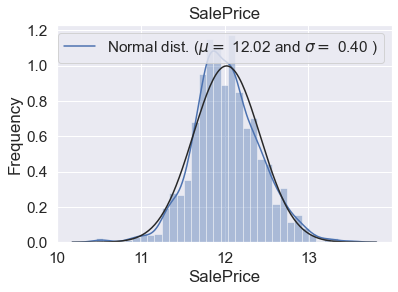

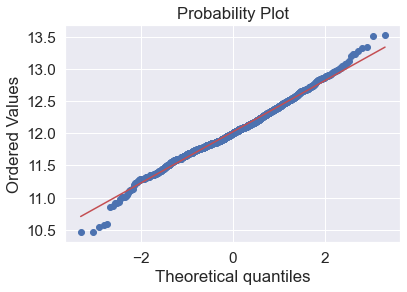

In [584]:
house["SalePrice"] = np.log(house["SalePrice"])
sns.distplot(house['SalePrice'] , fit=norm);
(mu, sigma) = norm.fit(house['SalePrice'])

plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice')

fig = plt.figure()
res = stats.probplot(house['SalePrice'], plot=plt)
plt.show()

In [585]:
house.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,12.247694
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,12.109011
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,12.317167
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,11.849398
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,12.429216


In [586]:
def fill_na(df):
    df = df.drop(['Utilities','PoolQC','MiscFeature','Alley'], axis=1)
    df["Fence"] = df["Fence"].fillna("None") 

    df["FireplaceQu"] = df["FireplaceQu"].fillna("None")
    
    df["LotFrontage"] = df["LotFrontage"].fillna(df["LotFrontage"].median())
    
    df["Functional"] = df["Functional"].fillna("Typ")
    
    df['KitchenQual'] = df['KitchenQual'].fillna(df['KitchenQual'].mode()[0])  
    
    df['Electrical'] = df['Electrical'].fillna(df['Electrical'].mode()[0])
    
    df['SaleType'] = df['SaleType'].fillna(df['SaleType'].mode()[0])
    
    df["MasVnrType"] = df["MasVnrType"].fillna("None")
    df["MasVnrArea"] = df["MasVnrArea"].fillna(0)      
    
    df['Exterior1st'] = df['Exterior1st'].fillna(df['Exterior1st'].mode()[0])
    df['Exterior2nd'] = df['Exterior2nd'].fillna(df['Exterior2nd'].mode()[0])
    
    df['MSZoning'] = df['MSZoning'].fillna(df['MSZoning'].mode()[0])
    
    df['MSSubClass'] = df['MSSubClass'].fillna("None")
    
    for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
        df[col] = df[col].fillna('None')
    
    for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
        df[col] = df[col].fillna(0)
    
    for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
        df[col] = df[col].fillna(0)
    
    for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
        df[col] = df[col].fillna('None')
        
    df['MSSubClass'] = df['MSSubClass'].astype(str) 
    df['YrSold'] = df['YrSold'].astype(str)
    df['MoSold'] = df['MoSold'].astype(str)
    
    return df

1. GarageCars and GarageArea are highly correlated. As GarageCars has a higher correlation with SalePrice, we will drop GarageArea.

2. GrLiveArea is highly correlated with TotRmsAbvGrd. We will remove TotRmsAbvGrd as GrLivArea has a higher correaltion with SalePrice.

3. TotalBsmtSF is highly correlated with 1stFlrSF. We will remove 1stFlrSF as TotalBsmtSF has a higher correaltion with SalePrice.

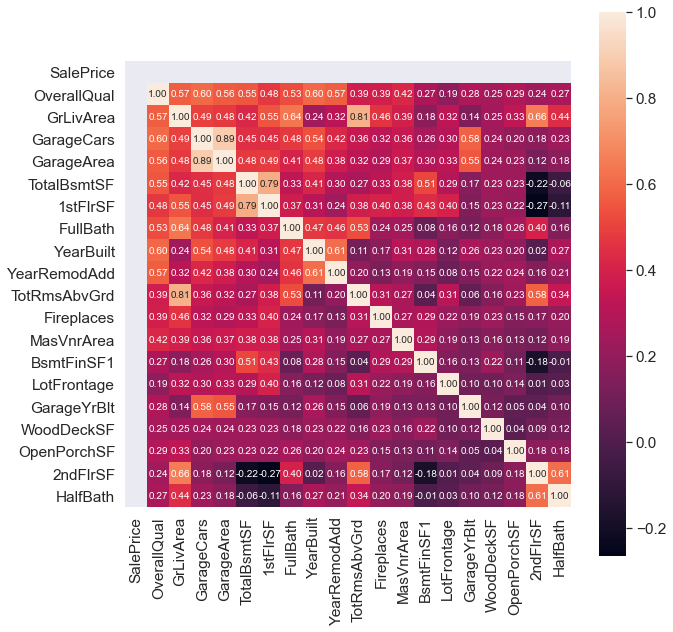

In [587]:
house = fill_na(house)
test_Id = test_data['Id']
test_data = test_data.drop(columns = ['Id'])
test_data = fill_na(test_data)
#house['SalePrice'] = np.log(house['SalePrice'])

y_train = house['SalePrice'].values
final_df = pd.concat((house, test_data)).reset_index(drop = True)

plt.figure(figsize=(10,10))
coorelation = final_df.corr()
k = 20
cols = coorelation.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(final_df[cols].values.T)
sns.set(font_scale=1.4)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()


In [588]:
#final_df.drop(['GarageArea', 'TotRmsAbvGrd', '1stFlrSF'],axis=1,inplace=True)

In [589]:
final_df = final_df.drop(columns = 'SalePrice')

In [590]:
final_test = []
for category in final_df:
    if pd.to_numeric(final_df[str(category)], errors='coerce').notnull().all() == False:
        final_test.append(str(category))

In [591]:
final_dummies = pd.get_dummies(final_df)

In [592]:
final_dummies

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,65.0,8450,7,5,2003,2003,196.0,706.0,0.0,150.0,...,0,0,0,1,0,0,0,0,1,0
1,80.0,9600,6,8,1976,1976,0.0,978.0,0.0,284.0,...,0,0,0,1,0,0,0,0,1,0
2,68.0,11250,7,5,2001,2002,162.0,486.0,0.0,434.0,...,0,0,0,1,0,0,0,0,1,0
3,60.0,9550,7,5,1915,1970,0.0,216.0,0.0,540.0,...,0,0,0,1,1,0,0,0,0,0
4,84.0,14260,8,5,2000,2000,350.0,655.0,0.0,490.0,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2911,21.0,1936,4,7,1970,1970,0.0,0.0,0.0,546.0,...,0,0,0,1,0,0,0,0,1,0
2912,21.0,1894,4,5,1970,1970,0.0,252.0,0.0,294.0,...,0,0,0,1,1,0,0,0,0,0
2913,160.0,20000,5,7,1960,1996,0.0,1224.0,0.0,0.0,...,0,0,0,1,1,0,0,0,0,0
2914,62.0,10441,5,5,1992,1992,0.0,337.0,0.0,575.0,...,0,0,0,1,0,0,0,0,1,0


In [593]:
labels = house[['SalePrice']]
print("check labels: ", labels.head(3))
labels.shape[0]

check labels:     SalePrice
0  12.247694
1  12.109011
2  12.317167


1457

In [594]:
features = final_dummies.reset_index(drop = True)

In [595]:
features

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,65.0,8450,7,5,2003,2003,196.0,706.0,0.0,150.0,...,0,0,0,1,0,0,0,0,1,0
1,80.0,9600,6,8,1976,1976,0.0,978.0,0.0,284.0,...,0,0,0,1,0,0,0,0,1,0
2,68.0,11250,7,5,2001,2002,162.0,486.0,0.0,434.0,...,0,0,0,1,0,0,0,0,1,0
3,60.0,9550,7,5,1915,1970,0.0,216.0,0.0,540.0,...,0,0,0,1,1,0,0,0,0,0
4,84.0,14260,8,5,2000,2000,350.0,655.0,0.0,490.0,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2911,21.0,1936,4,7,1970,1970,0.0,0.0,0.0,546.0,...,0,0,0,1,0,0,0,0,1,0
2912,21.0,1894,4,5,1970,1970,0.0,252.0,0.0,294.0,...,0,0,0,1,1,0,0,0,0,0
2913,160.0,20000,5,7,1960,1996,0.0,1224.0,0.0,0.0,...,0,0,0,1,1,0,0,0,0,0
2914,62.0,10441,5,5,1992,1992,0.0,337.0,0.0,575.0,...,0,0,0,1,0,0,0,0,1,0


In [596]:
X = features[:labels.shape[0]]
y = labels

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.05, random_state = 0)

print("number of training samples: ", len(X_train))
print("number of test samples:", len(y_test))

number of training samples:  1384
number of test samples: 73


In [597]:
X_train.head()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
1074,60.0,10800,5,8,1936,1989,0.0,626.0,0.0,170.0,...,0,0,0,1,0,0,0,0,1,0
161,110.0,13688,9,5,2003,2004,664.0,1016.0,0.0,556.0,...,0,0,0,1,0,0,0,0,1,0
764,80.0,10421,7,5,1988,1988,42.0,394.0,0.0,586.0,...,0,0,0,1,0,0,0,0,1,0
1319,107.0,10186,7,5,1992,1992,0.0,674.0,0.0,76.0,...,0,0,0,1,0,0,0,0,1,0
969,36.0,2268,7,5,2003,2004,106.0,567.0,0.0,197.0,...,0,0,0,1,0,0,0,0,1,0


In [598]:
y_train.head()

,SalePrice
1076,12.043554
161,12.929991
766,12.188418
1322,12.154779
971,12.061047


In [599]:
mlr = LinearRegression()
mlr.fit(X_train,y_train)
mlr.score(X_test, y_test)
mlr_score = mlr.score(X_test,y_test)
pred_mlr = mlr.predict(X_test)
expl_mlr = explained_variance_score(pred_mlr,y_test)

In [600]:
from sklearn.tree import DecisionTreeRegressor
tr_regressor = DecisionTreeRegressor(random_state=0)
tr_regressor.fit(X_train,y_train)
tr_regressor.score(X_test,y_test)
pred_tr = tr_regressor.predict(X_test)
decision_score=tr_regressor.score(X_test,y_test)
expl_tr = explained_variance_score(pred_tr,y_test)

In [601]:
from sklearn.ensemble import RandomForestRegressor
rf_regressor = RandomForestRegressor(n_estimators=100, random_state = 0)
rf_regressor.fit(X_train,y_train)
rf_regressor.score(X_test,y_test)
rf_pred =rf_regressor.predict(X_test)
rf_score=rf_regressor.score(X_test,y_test)
expl_rf = explained_variance_score(rf_pred,y_test)

In [602]:
print("Multiple Linear Regression Model Score is ",round(mlr.score(X_test,y_test)*100))
print("Decision tree  Regression Model Score is ",round(tr_regressor.score(X_test,y_test)*100))
print("Random Forest Regression Model Score is ",round(rf_regressor.score(X_test,y_test)*100))

models_score =pd.DataFrame({'Model':['Multiple Linear Regression','Decision Tree','Random forest Regression'],
                            'Score':[mlr_score,decision_score,rf_score],
                            'Explained Variance Score':[expl_mlr,expl_tr,expl_rf]
                           })
models_score.sort_values(by='Score',ascending=False)

Multiple Linear Regression Model Score is  88
Decision tree  Regression Model Score is  76
Random Forest Regression Model Score is  91


,Model,Score,Explained Variance Score
2,Random forest Regression,0.912851,0.914046
0,Multiple Linear Regression,0.882565,0.897880
1,Decision Tree,0.761799,0.795456


In [603]:
prediction_df = pd.DataFrame(np.exp(rf_regressor.predict(features[labels.shape[0]:])), columns = ['SalePrice'])
prediction_df['Id'] = test_Id
prediction_df.head()

,SalePrice,Id
0,125952.654448,1461
1,152525.890023,1462
2,180306.858480,1463
3,178385.974740,1464
4,199007.663625,1465


Accuracy of 0.14808

### Improve models

In [604]:
from sklearn.model_selection import cross_val_score

#Validation function
n_folds = 5

def rmsle_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train.values, y_train, scoring="neg_mean_squared_error", cv=n_folds))
    return(rmse)

In [606]:
score = rmsle_cv(rf_regressor)
print("Random Forest score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Random Forest score: 0.1409 (0.0126)



In [607]:
score = rmsle_cv(tr_regressor)
print("Decision Tree score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Decision Tree score: 0.2098 (0.0108)



In [608]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.svm import SVR

Svr = make_pipeline(RobustScaler(), SVR(gamma= 0.0003, kernel='rbf', C=15, epsilon=0.008))
score = rmsle_cv(Svr)
print("Support Vector Regression score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Support Vector Regression score: 0.1851 (0.0142)



In [609]:
from sklearn.linear_model import Lasso

lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0004, random_state=1))
score = rmsle_cv(lasso)
print("Lasso Regression score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Lasso Regression score: 0.1125 (0.0112)



In [610]:
from sklearn.linear_model import ElasticNet

ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.004, l1_ratio=.08, random_state=3))
score = rmsle_cv(ENet)
print("Elastic Regression score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Elastic Regression score: 0.1125 (0.0121)



In [611]:
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone

class AveragingModels(BaseEstimator, RegressorMixin):
    def __init__(self, models, weights):
        self.models = models
        self.weights = weights
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        
        predictions = np.column_stack([
            model.predict(X)*weight for model, weight in zip(self.models_, self.weights)
        ])
        
        return np.sum(predictions, axis=1)

In [612]:
averaged_models = AveragingModels(models = (rf_regressor, lasso, ENet), weights = (0.25, 0.375, 0.375))

score = rmsle_cv(averaged_models)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

 Averaged base models score: 0.1116 (0.0125)



In [613]:
averaged_models.fit(X_train, y_train)

AveragingModels(models=(RandomForestRegressor(random_state=0),
                        Pipeline(steps=[('robustscaler', RobustScaler()),
                                        ('lasso',
                                         Lasso(alpha=0.0004, random_state=1))]),
                        Pipeline(steps=[('robustscaler', RobustScaler()),
                                        ('elasticnet',
                                         ElasticNet(alpha=0.004, l1_ratio=0.08,
                                                    random_state=3))])),
                weights=(0.25, 0.375, 0.375))

In [614]:
averaged_models.score(X_test, y_test)

0.9392208957126431

In [496]:
prediction_df = pd.DataFrame(np.exp(averaged_models.predict(features[labels.shape[0]:])), columns = ['SalePrice'])
prediction_df['Id'] = test_Id
prediction_df.head()

,SalePrice,Id
0,115534.038096,1461
1,148944.942741,1462
2,179415.383751,1463
3,196400.353370,1464
4,192197.925343,1465


In [664]:
prediction_df.to_csv('my_predictions.csv',index=False)

Accuracy of 0.12985